## 定义模型

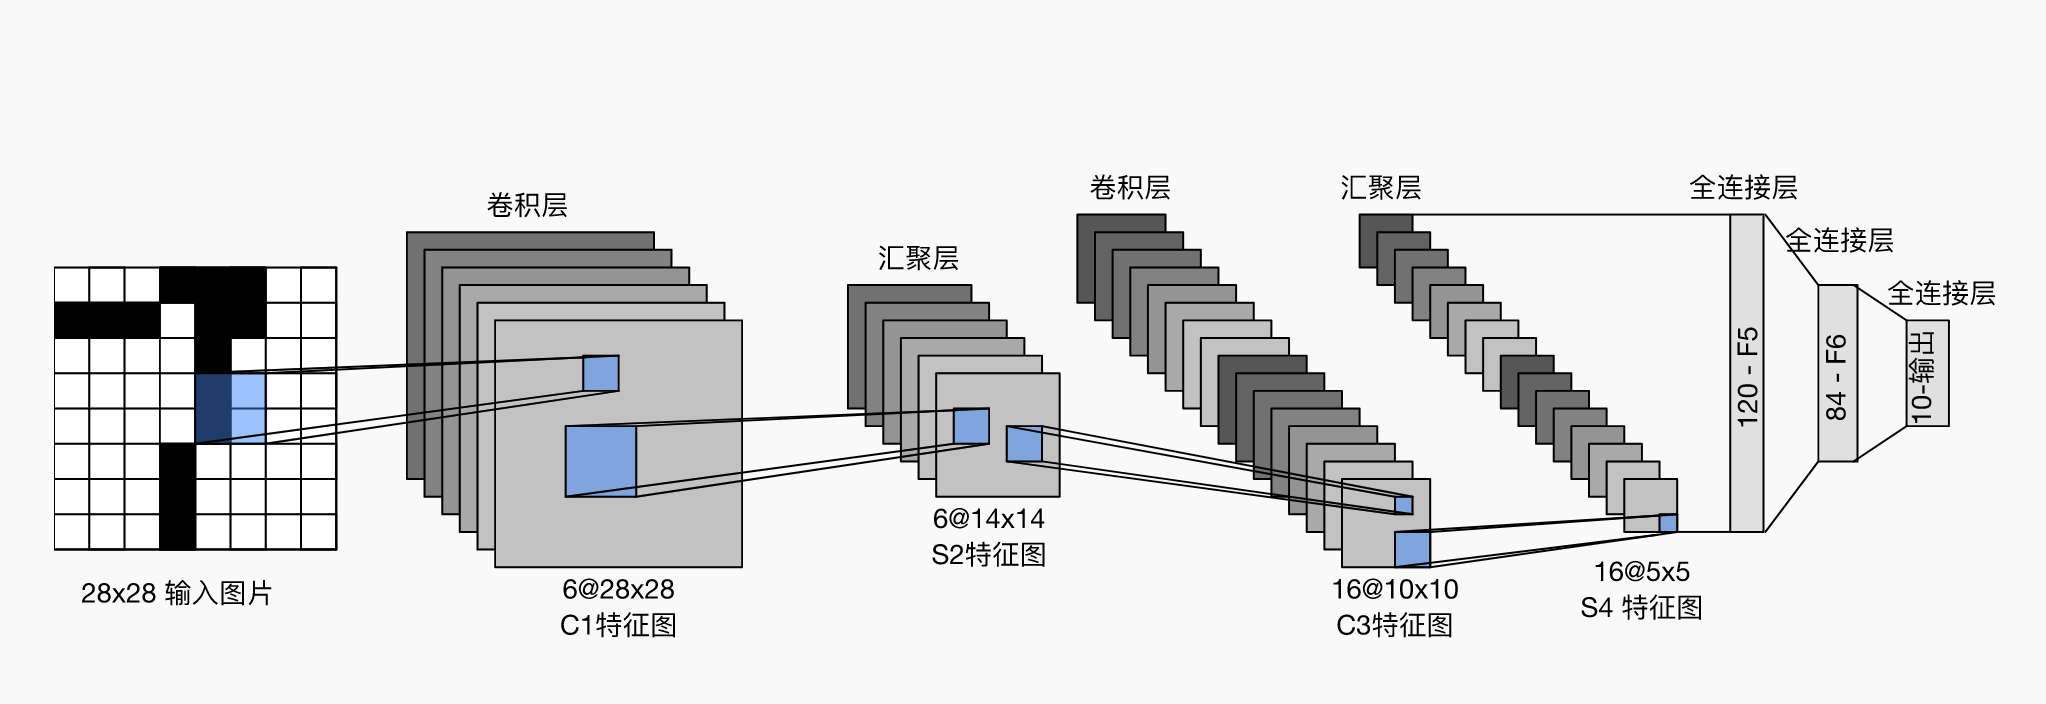

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [22]:
net = nn.Sequential(
    # input channels num，output channels num
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(), # 6*28*28
    nn.AvgPool2d(kernel_size=2, stride=2), # 6 14 14
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(), # 16 * 10 * 10
    nn.AvgPool2d(kernel_size=2, stride=2), # 16 5 5, 步长等于2，直接高宽除2
    nn.Flatten(), # 把16 * 5 *5 flatten到一维 1*400
    nn.Linear(16 * 5 *5, 120), nn.Sigmoid(), # 输入特征400，输出特征120
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [3]:
X = torch.rand(size=(1,1,28,28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)   # 下面第一个位置的1是指的批量大小；

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


## 模型训练

LeNet在Fashion-MNIST数据集上的表现

In [4]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [12]:
device = torch.device('cuda:3')

In [14]:
device = torch.device('cuda:3')

### 使用GPU计算模型在数据集上的精度

In [15]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

### 训练

In [16]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.474, train acc 0.822, test acc 0.781
21989.8 examples/sec on cuda:3


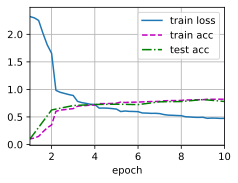

In [17]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, device)

loss 0.192, train acc 0.927, test acc 0.905
34600.7 examples/sec on cuda:3


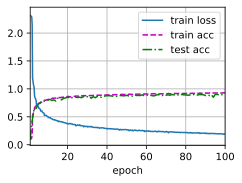

In [18]:
lr, num_epochs = 0.8, 100
train_ch6(net, train_iter, test_iter, num_epochs, lr, device)

loss 0.364, train acc 0.863, test acc 0.820
34310.3 examples/sec on cuda:3


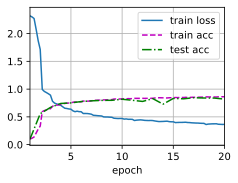

In [19]:
lr, num_epochs = 1.0, 20
train_ch6(net, train_iter, test_iter, num_epochs, lr, device)

loss 2.304, train acc 0.101, test acc 0.100
34516.6 examples/sec on cuda:3


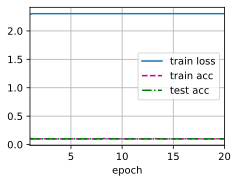

In [21]:
# sigmoid 换成 relu
lr, num_epochs = 1.0, 20
train_ch6(net, train_iter, test_iter, num_epochs, lr, device)